# Data Science Fundamentals Project

The dataset that we've selected for this project is a dataset regarding superconductivity available on both the UCI machine learning repository as well as Kaggle. <br> Link to UCI : https://archive.ics.uci.edu/dataset/464/superconductivty+data 
<br> Link to Kaggle : https://www.kaggle.com/c/superconductivity/overview
<br>

<b>(to insert here explanation of why we've selected this dataset and how it fits in our domain)</b>

In [147]:
pip install tensorflow

   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 2.1/376.0 MB 11.7 MB/s eta 0:00:32
   ---------------------------------------- 4.5/376.0 MB 11.7 MB/s eta 0:00:32
    --------------------------------------- 6.6/376.0 MB 10.9 MB/s eta 0:00:34
    --------------------------------------- 7.9/376.0 MB 9.7 MB/s eta 0:00:38
    --------------------------------------- 8.9/376.0 MB 8.8 MB/s eta 0:00:42
   - -------------------------------------- 9.7/376.0 MB 7.9 MB/s eta 0:00:47
   - -------------------------------------- 10.5/376.0 MB 7.4 MB/s eta 0:00:50
   - -------------------------------------- 11.5/376.0 MB 7.1 MB/s eta 0:00:52
   - -------------------------------------- 12.8/376.0 MB 6.9 MB/s eta 0:00:53
   - -------------------------------------- 14.2/376.0 MB 6.9 MB/s eta 0:00:53
   - -------------------------------------- 15.7/376.0 MB 6.9 MB/s eta 0:00:53
   - -------------------------------------- 17.3/376.0 MB 6.9 M

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

There are two files : <b>"train.csv"</b> and <b>"unique_m.csv".</b>
- <b> train.csv </b> contains the number of elements, mean, geometric mean, standard deviation, weighted standard deviation, entropy, weighted entropy, range of various properties such as the fusion heat, number of valence electrons, thermal conductivity etc of the elements present in each superconductor. It also contains the critical temperature.
- <b> unique_m </b> contains chemical formula and the columns for 86 elements indicating the quantity present (as relative number of atoms) in the superconductor.

In [7]:
df = pd.read_csv("train.csv")
elements = pd.read_csv("unique_m.csv")

In [8]:
df["chemical_formula"] = elements["material"]

In [9]:
df.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp,chemical_formula
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0,Ba0.2La1.8Cu1O4
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0,Ba0.1La1.9Cu1O4
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0,Ba0.15La1.85Cu1O4
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0,Ba0.3La1.7Cu1O4


In [10]:
elements.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [11]:
print("Shape of the dataset:", df.shape)
print("\nColumn Types and Non-Null Counts:")
print(df.info())

Shape of the dataset: (21263, 83)

Column Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 83 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie   

In [12]:
print("Shape of the dataset:", df.shape)
print("\nColumn Types and Non-Null Counts:")
print(elements.info())

Shape of the dataset: (21263, 83)

Column Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 88 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   H              21263 non-null  float64
 1   He             21263 non-null  int64  
 2   Li             21263 non-null  float64
 3   Be             21263 non-null  float64
 4   B              21263 non-null  float64
 5   C              21263 non-null  float64
 6   N              21263 non-null  float64
 7   O              21263 non-null  float64
 8   F              21263 non-null  float64
 9   Ne             21263 non-null  int64  
 10  Na             21263 non-null  float64
 11  Mg             21263 non-null  float64
 12  Al             21263 non-null  float64
 13  Si             21263 non-null  float64
 14  P              21263 non-null  float64
 15  S              21263 non-null  float64
 16  Cl             21263 non-

In [13]:
print("\nMissing Values in Each Column:")
print(df.isnull().sum().sort_values(ascending=False))


Missing Values in Each Column:
number_of_elements              0
wtd_mean_ThermalConductivity    0
wtd_std_FusionHeat              0
std_FusionHeat                  0
wtd_range_FusionHeat            0
                               ..
wtd_entropy_atomic_radius       0
entropy_atomic_radius           0
wtd_gmean_atomic_radius         0
gmean_atomic_radius             0
chemical_formula                0
Length: 83, dtype: int64


In [14]:
print("\nStatistical summary:")
print(df.describe())


Statistical summary:
       number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
count        21263.000000      21263.000000          21263.000000   
mean             4.115224         87.557631             72.988310   
std              1.439295         29.676497             33.490406   
min              1.000000          6.941000              6.423452   
25%              3.000000         72.458076             52.143839   
50%              4.000000         84.922750             60.696571   
75%              5.000000        100.404410             86.103540   
max              9.000000        208.980400            208.980400   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
count       21263.000000           21263.000000         21263.000000   
mean           71.290627              58.539916             1.165608   
std            31.030272              36.651067             0.364930   
min             5.320573               1.960849             0.000000

In [15]:
print("\nNumber of duplicate rows:", df.duplicated().sum())


Number of duplicate rows: 0


<b> Since there's no duplpicate rows maybe we don't need this next part</b>

In [17]:
# Find and display all duplicate rows
duplicates = df[df.duplicated(keep=False)]

# Show all duplicated rows
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
print(duplicates)

Empty DataFrame
Columns: [number_of_elements, mean_atomic_mass, wtd_mean_atomic_mass, gmean_atomic_mass, wtd_gmean_atomic_mass, entropy_atomic_mass, wtd_entropy_atomic_mass, range_atomic_mass, wtd_range_atomic_mass, std_atomic_mass, wtd_std_atomic_mass, mean_fie, wtd_mean_fie, gmean_fie, wtd_gmean_fie, entropy_fie, wtd_entropy_fie, range_fie, wtd_range_fie, std_fie, wtd_std_fie, mean_atomic_radius, wtd_mean_atomic_radius, gmean_atomic_radius, wtd_gmean_atomic_radius, entropy_atomic_radius, wtd_entropy_atomic_radius, range_atomic_radius, wtd_range_atomic_radius, std_atomic_radius, wtd_std_atomic_radius, mean_Density, wtd_mean_Density, gmean_Density, wtd_gmean_Density, entropy_Density, wtd_entropy_Density, range_Density, wtd_range_Density, std_Density, wtd_std_Density, mean_ElectronAffinity, wtd_mean_ElectronAffinity, gmean_ElectronAffinity, wtd_gmean_ElectronAffinity, entropy_ElectronAffinity, wtd_entropy_ElectronAffinity, range_ElectronAffinity, wtd_range_ElectronAffinity, std_Electron

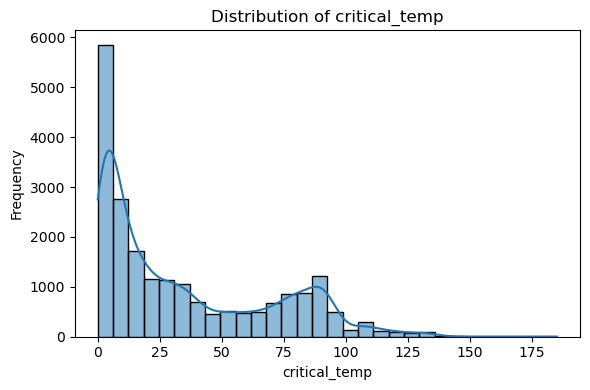

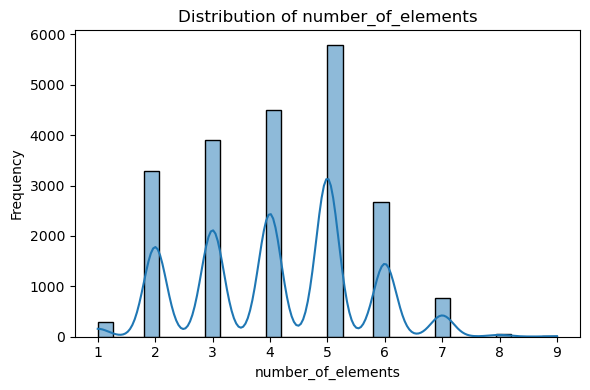

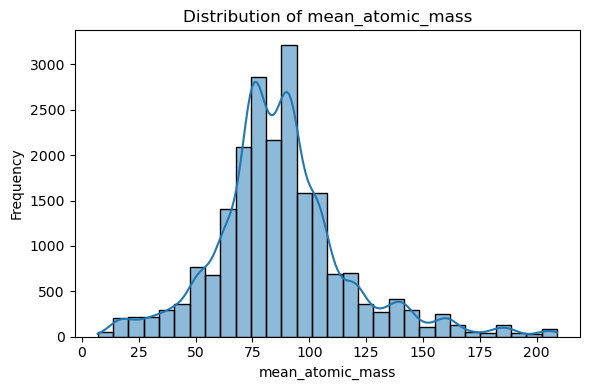

In [18]:
selected_cols = ['critical_temp', 'number_of_elements', 'mean_atomic_mass']
for col in selected_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

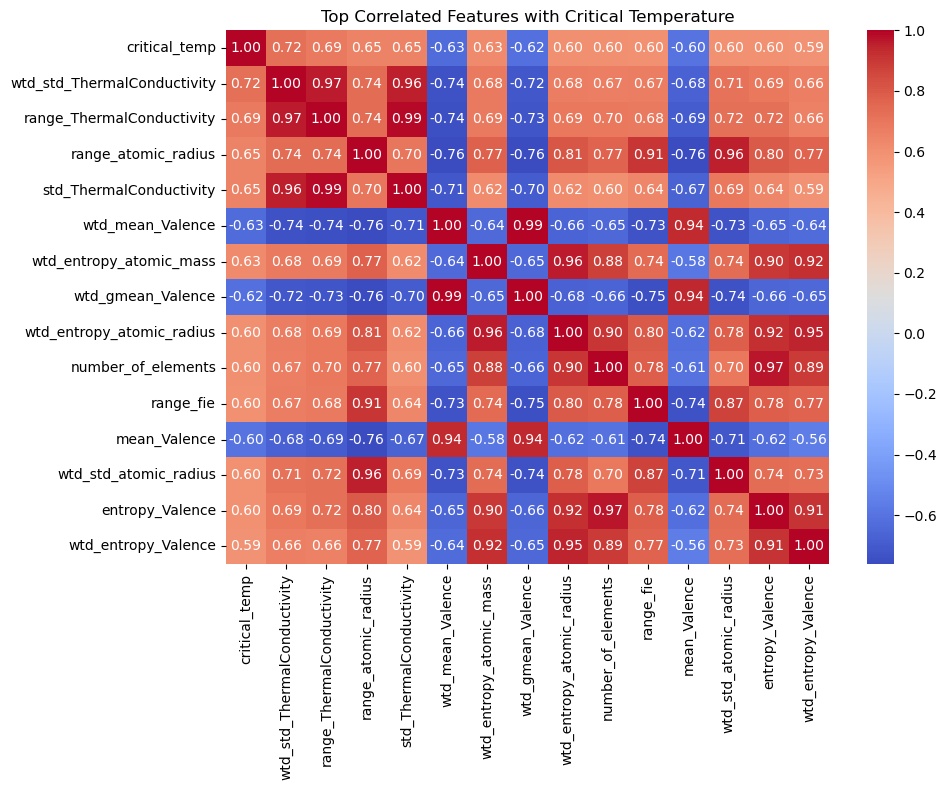

In [19]:
plt.figure(figsize=(10, 8))
corr_matrix = df.corr(numeric_only=True)
top_corr = corr_matrix['critical_temp'].abs().sort_values(ascending=False).head(15).index
sns.heatmap(df[top_corr].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Top Correlated Features with Critical Temperature')
plt.tight_layout()
plt.show()

In [20]:
from scipy.stats import zscore
z_scores = np.abs(zscore(df['critical_temp']))
outliers = df[z_scores > 3]
print(f"\nNumber of outliers in 'critical_temp' (z-score > 3): {len(outliers)}")



Number of outliers in 'critical_temp' (z-score > 3): 4


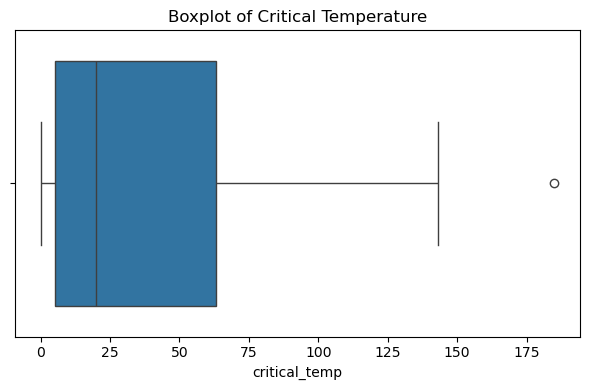

In [21]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['critical_temp'])
plt.title('Boxplot of Critical Temperature')
plt.tight_layout()
plt.show()


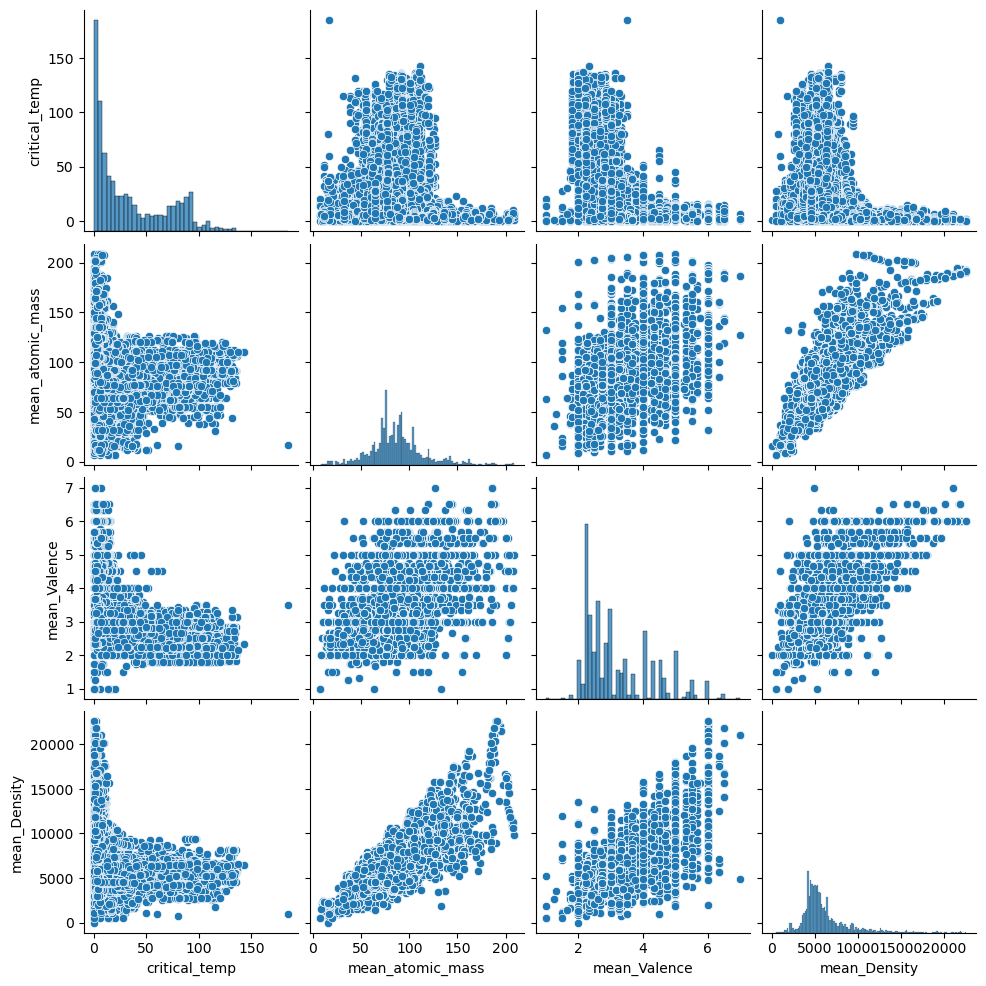

In [22]:
selected = ['critical_temp', 'mean_atomic_mass', 'mean_Valence', 'mean_Density']
sns.pairplot(df[selected])
plt.show()

In [150]:
# considering only the most correlated features
X = df[top_corr]
y = df["critical_temp"]

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [162]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [184]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [186]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1228.0758 - mae: 22.4450 - val_loss: 50.6352 - val_mae: 5.2497
Epoch 2/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 91.8644 - mae: 6.8902 - val_loss: 14.4931 - val_mae: 2.7198
Epoch 3/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 74.2273 - mae: 5.9223 - val_loss: 12.9657 - val_mae: 2.8628
Epoch 4/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 63.9860 - mae: 5.4345 - val_loss: 5.8685 - val_mae: 1.9126
Epoch 5/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 60.4913 - mae: 5.1386 - val_loss: 6.0682 - val_mae: 2.0195
Epoch 6/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 58.8296 - mae: 5.0061 - val_loss: 2.6129 - val_mae: 1.1139
Epoch 7/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 53.1826 - mae: 4.7718 - val_loss: 1.9783 - val_mae: 1.0111
Epoch 8/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 55.1679 - mae: 4.7300 - val_loss: 2.8524 - val_mae: 1.3007
Epoch 9/100
426/426 ━━━━━━━━━━━━━━

In [188]:
loss, mae = model.evaluate(X_test_scaled, y_test)

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7405 - mae: 1.1427


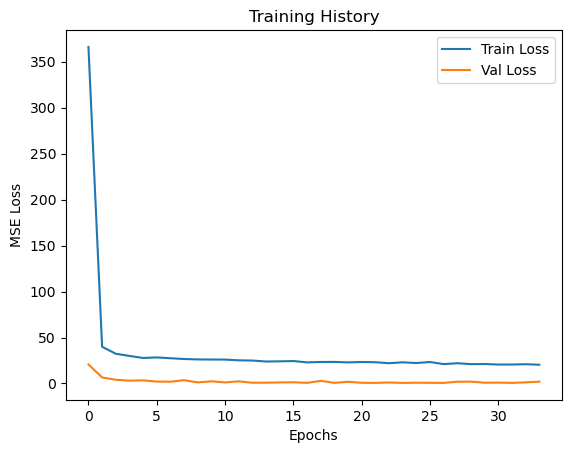

In [176]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.show()

In [248]:
output = pd.DataFrame(y_test)
output["predicted"] = model.predict(X_test_scaled)
output

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,critical_temp,predicted
13976,6.40,6.348896
1710,91.20,92.513947
369,38.00,39.158619
1698,19.00,19.681067
13540,11.00,11.262191
...,...,...
6246,83.60,85.196281
5170,83.50,85.146370
14614,3.50,4.481394
13134,8.70,8.569187


### trying to use PCA instead of dropping columns that are irrelevant
just in case this accuracy isnt good enough, we could try to use pca to reduce dimensionality instead of simply dropping other columns

In [23]:
atomic_mass_features = df[[
    "mean_atomic_mass", "wtd_mean_atomic_mass", "gmean_atomic_mass", "wtd_gmean_atomic_mass",
    "entropy_atomic_mass", "wtd_entropy_atomic_mass", "range_atomic_mass", "wtd_range_atomic_mass",
    "std_atomic_mass", "wtd_std_atomic_mass"
]]


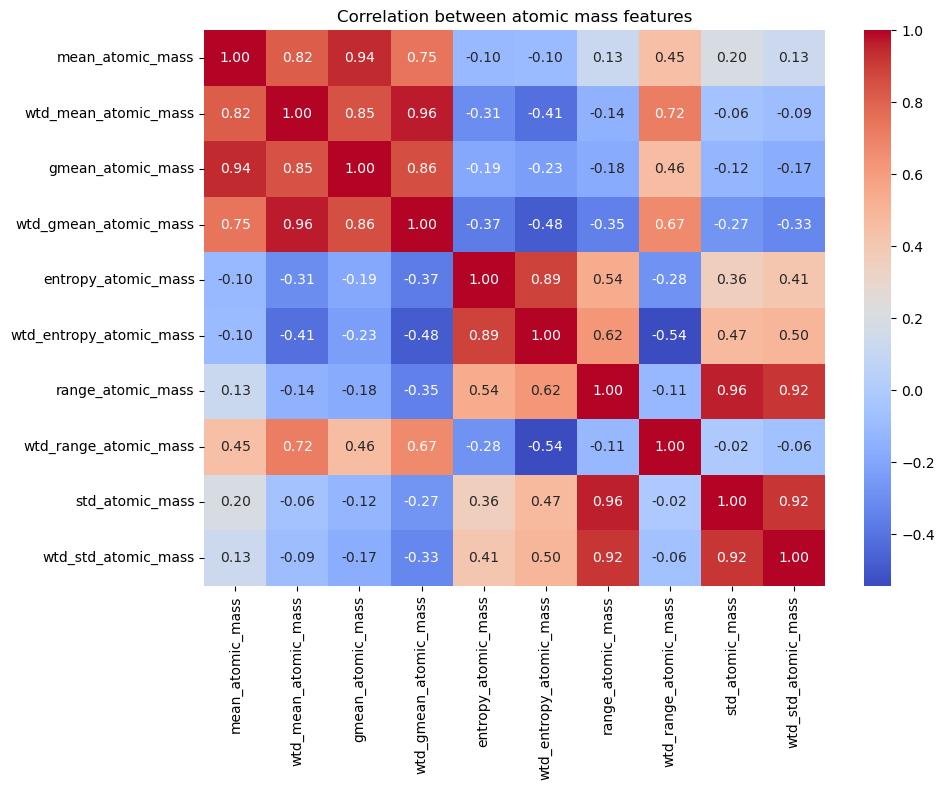

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(atomic_mass_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between atomic mass features')
plt.tight_layout()
plt.show()

In [103]:
# Standardize the valence features
scaler = StandardScaler()
atomic_mass_features_scaled = scaler.fit_transform(atomic_mass_features)

# Apply PCA to reduce to 2 components
pca = PCA(n_components=3)
atomic_mass_pca = pca.fit_transform(atomic_mass_features_scaled)

In [105]:
pca.explained_variance_ratio_.sum()

0.9097247393850276

In [25]:
fie_features = df[[
    "mean_fie", "wtd_mean_fie", "gmean_fie", "wtd_gmean_fie",
    "entropy_fie", "wtd_entropy_fie", "range_fie", "wtd_range_fie",
    "std_fie", "wtd_std_fie"
]]

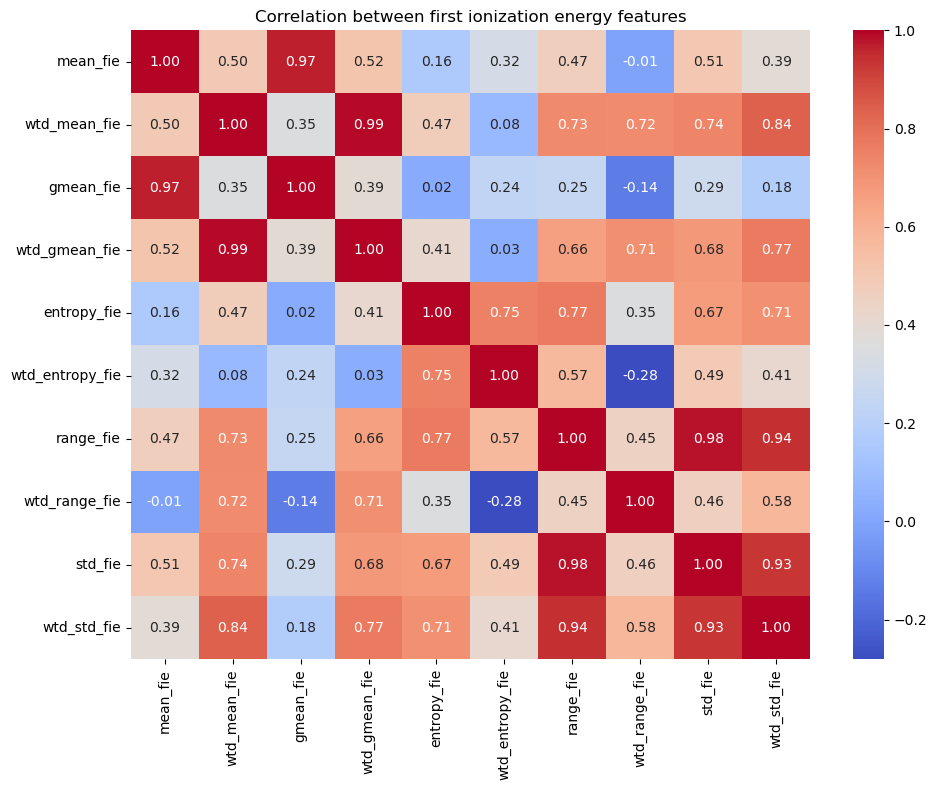

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(fie_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between first ionization energy features')
plt.tight_layout()
plt.show()

In [109]:
atomic_radius_features = df[[
    "mean_atomic_radius", "wtd_mean_atomic_radius", "gmean_atomic_radius", "wtd_gmean_atomic_radius",
    "entropy_atomic_radius", "wtd_entropy_atomic_radius", "range_atomic_radius", "wtd_range_atomic_radius",
    "std_atomic_radius", "wtd_std_atomic_radius"
]]

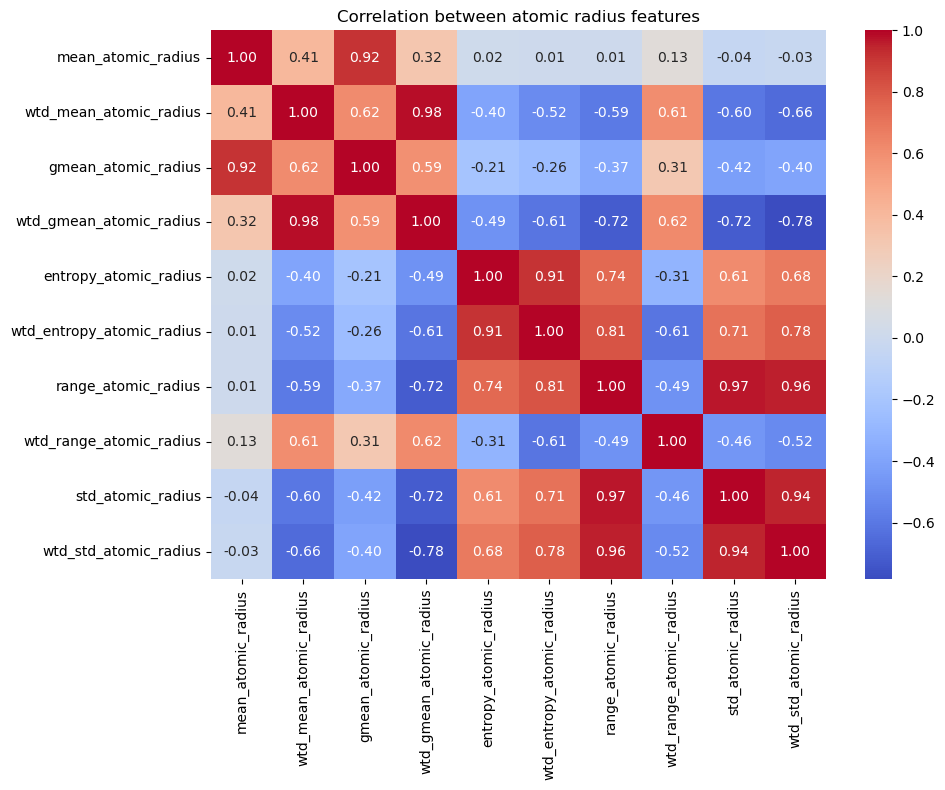

In [107]:
plt.figure(figsize=(10, 8))
sns.heatmap(atomic_radius_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between atomic radius features')
plt.tight_layout()
plt.show()

In [55]:
density_features = df[[
    "mean_Density", "wtd_mean_Density", "gmean_Density", "wtd_gmean_Density",
    "entropy_Density", "wtd_entropy_Density", "range_Density", "wtd_range_Density",
    "std_Density", "wtd_std_Density"
]]

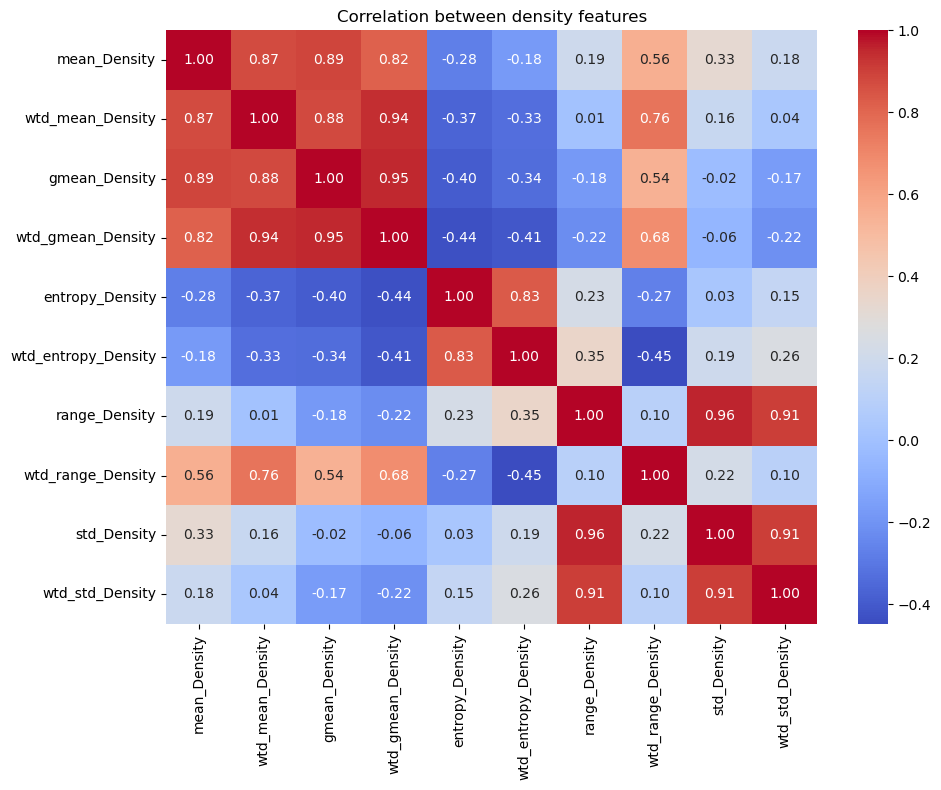

In [59]:
plt.figure(figsize=(10, 8))
sns.heatmap(density_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between density features')
plt.tight_layout()
plt.show()

In [70]:
electron_affinity_features = df[[
    "mean_ElectronAffinity", "wtd_mean_ElectronAffinity", "gmean_ElectronAffinity", "wtd_gmean_ElectronAffinity",
    "entropy_ElectronAffinity", "wtd_entropy_ElectronAffinity", "range_ElectronAffinity", "wtd_range_ElectronAffinity",
    "std_ElectronAffinity", "wtd_std_ElectronAffinity"
]]

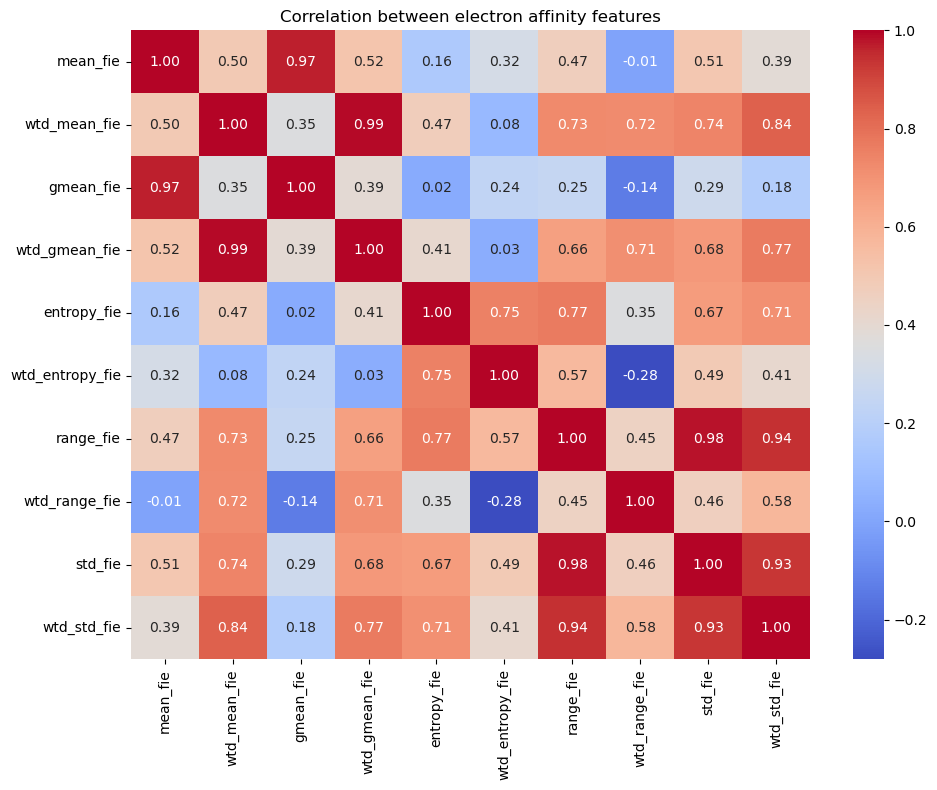

In [61]:
plt.figure(figsize=(10, 8))
sns.heatmap(fie_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between electron affinity features')
plt.tight_layout()
plt.show()

In [63]:
fusion_heat_features = df[[
    "mean_FusionHeat", "wtd_mean_FusionHeat", "gmean_FusionHeat", "wtd_gmean_FusionHeat",
    "entropy_FusionHeat", "wtd_entropy_FusionHeat", "range_FusionHeat", "wtd_range_FusionHeat",
    "std_FusionHeat", "wtd_std_FusionHeat"
]]

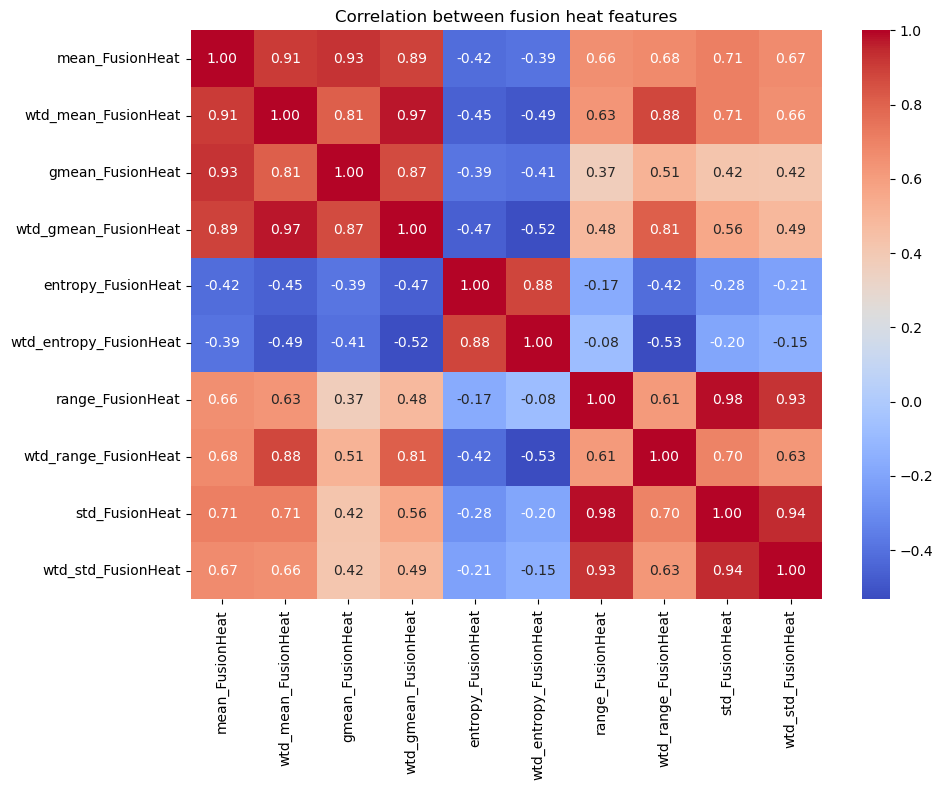

In [73]:
plt.figure(figsize=(10, 8))
sns.heatmap(fusion_heat_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between fusion heat features')
plt.tight_layout()
plt.show()

In [75]:
valence_features = df[[
    "mean_Valence", "wtd_mean_Valence", "gmean_Valence", "wtd_gmean_Valence",
    "entropy_Valence", "wtd_entropy_Valence", "range_Valence", "wtd_range_Valence",
    "std_Valence", "wtd_std_Valence"
]]

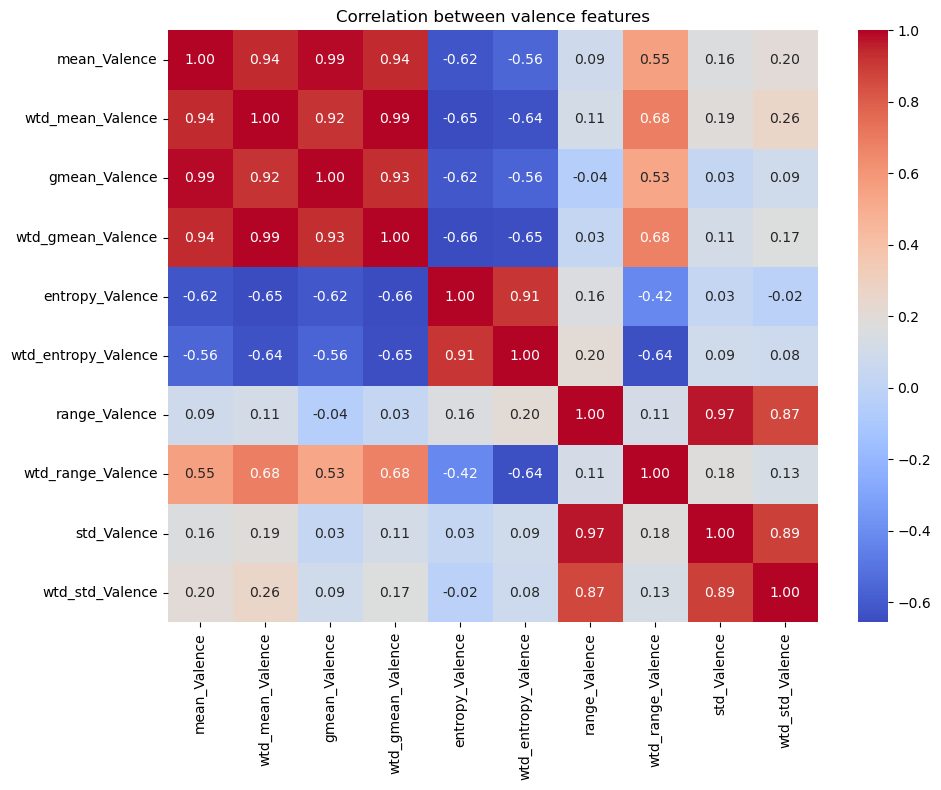

In [77]:
plt.figure(figsize=(10, 8))
sns.heatmap(valence_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between valence features')
plt.tight_layout()
plt.show()

In [115]:
thermal_conductivity_features = df[[
    "mean_ThermalConductivity", "wtd_mean_ThermalConductivity", "gmean_ThermalConductivity", "wtd_gmean_ThermalConductivity",
    "entropy_ThermalConductivity", "wtd_entropy_ThermalConductivity", "range_ThermalConductivity", "wtd_range_ThermalConductivity",
    "std_ThermalConductivity", "wtd_std_ThermalConductivity", "critical_temp"
]]

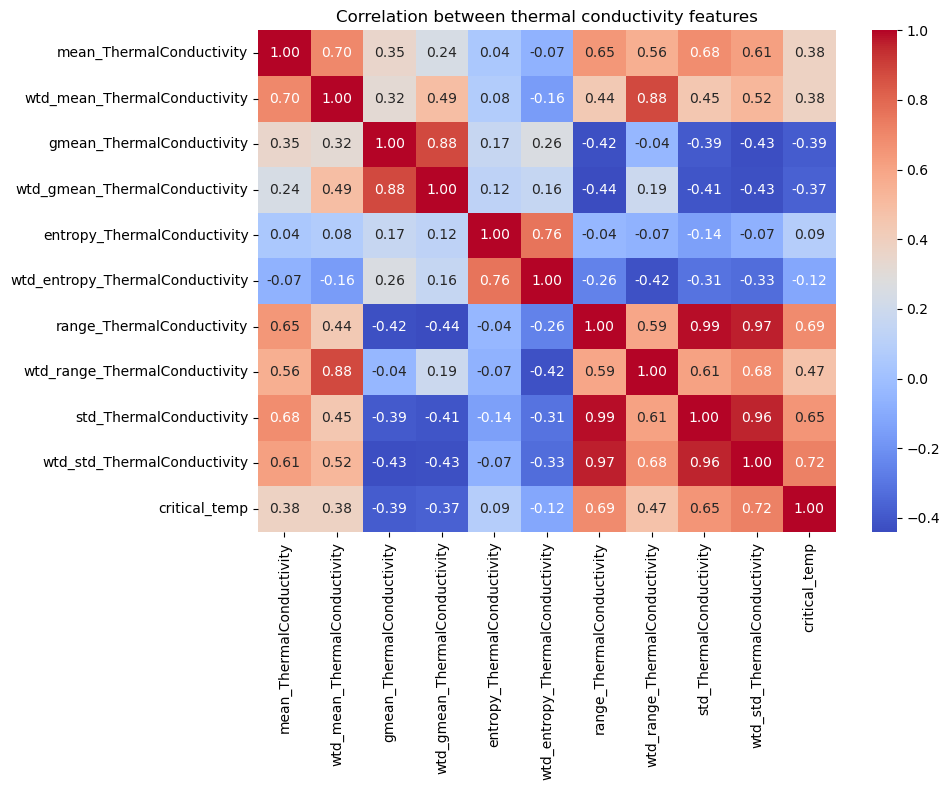

In [119]:
plt.figure(figsize=(10, 8))
sns.heatmap(thermal_conductivity_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between thermal conductivity features')
plt.tight_layout()
plt.show()

In [125]:
X = df.drop(columns=['critical_temp', 'chemical_formula'])
y = df['critical_temp']

mi_scores = mutual_info_regression(X, y)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("Low MI features:", mi_series[mi_series < 0.01].index.tolist())

Low MI features: []


In [127]:
print(mi_series)

std_fie                            0.957925
gmean_Density                      0.950051
std_ThermalConductivity            0.937653
entropy_atomic_mass                0.935307
entropy_atomic_radius              0.929550
entropy_Density                    0.917193
range_ElectronAffinity             0.914794
entropy_ElectronAffinity           0.911304
range_fie                          0.909864
std_ElectronAffinity               0.900054
entropy_FusionHeat                 0.899544
mean_ThermalConductivity           0.889083
gmean_FusionHeat                   0.883979
range_Density                      0.879224
wtd_gmean_Valence                  0.871779
wtd_mean_Valence                   0.868573
std_atomic_radius                  0.864869
gmean_ElectronAffinity             0.862285
gmean_ThermalConductivity          0.852498
entropy_fie                        0.838802
mean_FusionHeat                    0.836142
gmean_atomic_mass                  0.835795
wtd_gmean_Density               